In [1]:
import pyart
import os
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 
import warnings
from copy import deepcopy
from __future__ import print_function
warnings.filterwarnings("ignore")
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [2]:
#first lets look at a SPOL file from AIME given they had a hill there
#0.6960° S, 73.1556° E

In [3]:
spol_radar = pyart.io.read('/data/radar/ENA/cfrad.20111026_124532.063_to_20111026_125028.172_SPOL_v839_SUR.nc')

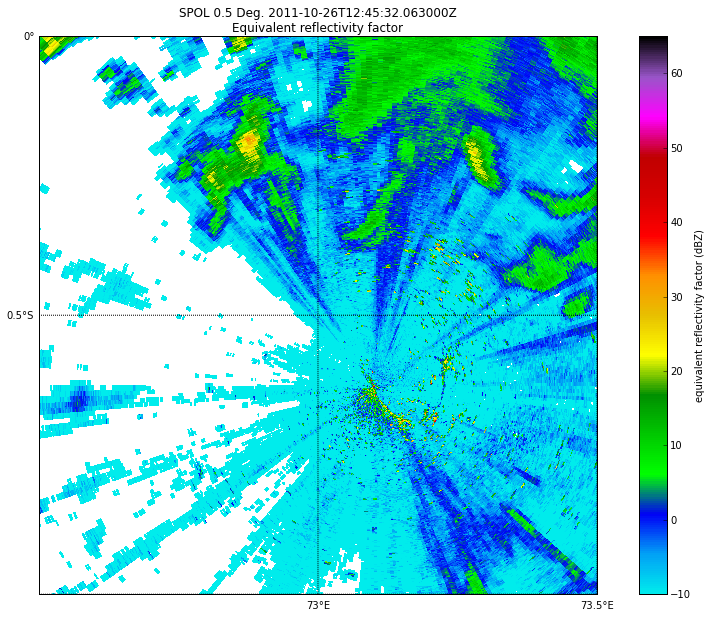

In [4]:
my_figure = plt.figure(figsize=[15,10])
my_display = pyart.graph.RadarMapDisplay(spol_radar)
lat_lines = np.arange(-4,4,.5)
lon_lines = np.arange(70, 76, .5)
my_display.plot_ppi_map('DBZ_S', 0, 
                        lat_lines=lat_lines,
                       lon_lines=lon_lines,
                       max_lon = 73.5, max_lat = 0.,
                       min_lon = 72.5, min_lat = -1)


In [5]:
print(spol_radar.fields.keys())

[u'DBZ_NAA_S', u'RATE_HYBRID', u'RHOHV_NNC_S', u'TEMP_FOR_PID', u'SNRVX_K', u'DBZ_NAA_K', u'DBMVX_S', u'DBZ_K', u'RHOHV_S', u'RATE_KDP', u'PID', u'SNRHC_S', u'RATE_Z_ZDR', u'KDP_S', u'SNRHC_K', u'DBMVC_S', u'PSOB_S', u'DBZ_S', u'WIDTH_S', u'SNRVX_S', u'CMD_FLAG_S', u'LDRH_K', u'CMD_S', u'PHIDP_S', u'DBMHC_K', u'LDRV_S', u'VEL_ALT_S', u'NCP_S', u'RATE_KDP_ZDR', u'SNRHX_S', u'CPA_S', u'VEL_HV_S', u'LDRH_S', u'DBMHC_S', u'DBMHX_S', u'CLUT_S', u'ZDR_S', u'RATE_ZH', u'VEL_S', u'SNRVC_S', u'DBMVX_K']


In [4]:
in_dir = '/data/radar/ENA/'
all_spols = os.listdir(in_dir)
all_spols.sort()
good_spols = []
for fn in all_spols:
    if 'cfrad' in fn:
        good_spols.append(fn)
    

In [5]:
print(len(good_spols))

125


In [35]:
all_radars = [pyart.io.read(in_dir + fn).fields['DBZ_S']['data']\
              for fn in good_spols]
bad = []
for i in range(len(all_radars)):
    if all_radars[i].shape != (2880, 979):
        bad.append(i)
for this_bad in bad:
    del all_radars[this_bad]
z_stack = np.stack(all_radars)
z_stack_masked = np.ma.masked_where(z_stack < -160, z_stack )
new_z = np.ma.mean(z_stack_masked, axis = 0)
print(new_z.shape)
del all_radars

In [37]:
all_radars_power = []
all_radars_z = []
all_radars_ncp = []
all_radars_rhv =[]

for fn in good_spols:
    print(fn)
    rd = pyart.io.read(in_dir + fn)
    if rd.fields['DBZ_S']['data'].shape == (2880, 979):
        all_radars_power.append(rd.fields['DBMHC_S']['data'])
        all_radars_z.append(rd.fields['DBZ_S']['data'])
        all_radars_ncp.append(rd.fields['NCP_S']['data'])
        all_radars_rhv.append(rd.fields['RHOHV_NNC_S']['data'])
        del rd
    else:
        print(fn, ' skipped')
    


cfrad.20111026_100032.206_to_20111026_100528.301_SPOL_v806_SUR.nc
cfrad.20111026_101531.954_to_20111026_102028.080_SPOL_v809_SUR.nc
cfrad.20111026_103032.121_to_20111026_103528.220_SPOL_v812_SUR.nc
cfrad.20111026_104531.939_to_20111026_105028.053_SPOL_v815_SUR.nc
cfrad.20111026_110032.121_to_20111026_110528.496_SPOL_v818_SUR.nc
cfrad.20111026_111531.964_to_20111026_112028.285_SPOL_v821_SUR.nc
cfrad.20111026_113032.124_to_20111026_113528.212_SPOL_v824_SUR.nc
cfrad.20111026_114532.024_to_20111026_115028.146_SPOL_v827_SUR.nc
cfrad.20111026_120031.863_to_20111026_120527.965_SPOL_v830_SUR.nc
cfrad.20111026_121532.057_to_20111026_122029.016_SPOL_v833_SUR.nc
cfrad.20111026_123031.891_to_20111026_123527.979_SPOL_v836_SUR.nc
cfrad.20111026_124532.063_to_20111026_125028.172_SPOL_v839_SUR.nc
cfrad.20111026_130031.895_to_20111026_130528.378_SPOL_v842_SUR.nc
cfrad.20111026_131532.041_to_20111026_132028.155_SPOL_v845_SUR.nc
cfrad.20111026_133032.124_to_20111026_133528.474_SPOL_v848_SUR.nc
cfrad.2011

In [38]:
z_stack = np.stack(all_radars_z)
p_stack = np.stack(all_radars_power)
ncp_stack = np.stack(all_radars_ncp)
rhv_stack = np.stack(all_radars_rhv)

rhv_too_low = rhv_stack < .8
ncp_too_low = ncp_stack < .5
z_invalid = z_stack < -160

data_is_bad = np.logical_or(ncp_too_low, rhv_too_low)
data_should_be_masked = np.logical_or(z_invalid, data_is_bad)

z_stack_masked = np.ma.masked_where(data_should_be_masked, z_stack)
p_stack_masked = np.ma.masked_where(data_should_be_masked, p_stack)
new_z = np.ma.mean(z_stack_masked, axis = 0)
new_p = np.ma.mean(p_stack_masked, axis = 0)


In [39]:
out_radar = deepcopy(spol_radar)
first_z = out_radar.fields['DBZ_S']
first_p = out_radar.fields['DBMHC_S']
for item in out_radar.fields.keys():
    del out_radar.fields[item]

first_z['data'] = new_z
out_radar.add_field('mean_z', first_z, replace_existing=True)
first_p['data'] = new_p
out_radar.add_field('mean_p', first_p, replace_existing=True)


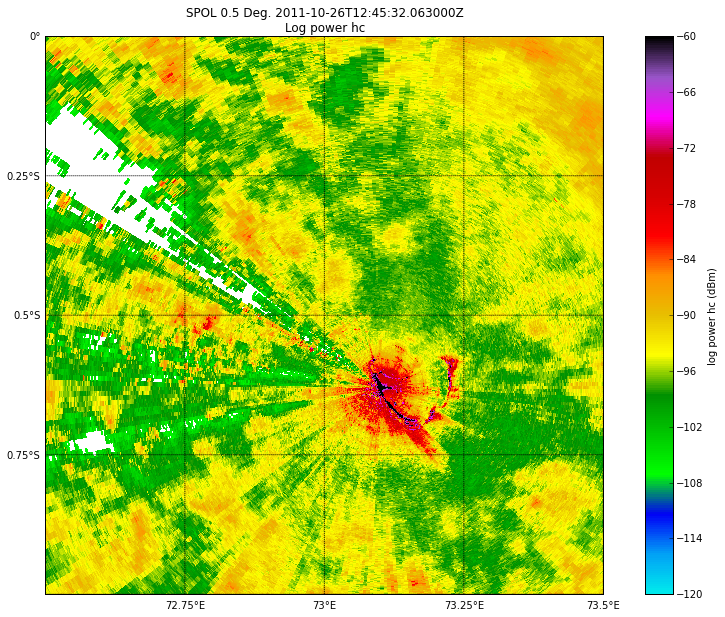

In [41]:
my_figure = plt.figure(figsize=[15,10])
my_display = pyart.graph.RadarMapDisplay(out_radar)
lat_lines = np.arange(-4,4,.25)
lon_lines = np.arange(70, 76, .25)
my_display.plot_ppi_map('mean_p', 0, 
                        lat_lines=lat_lines,
                       lon_lines=lon_lines,
                       max_lon = 73.5, max_lat = 0.,
                       min_lon = 72.5, min_lat = -1, 
                        cmap = pyart.graph.cm.NWSRef, 
                        mask_outside = False, 
                       vmin = -60, vmax = -120)


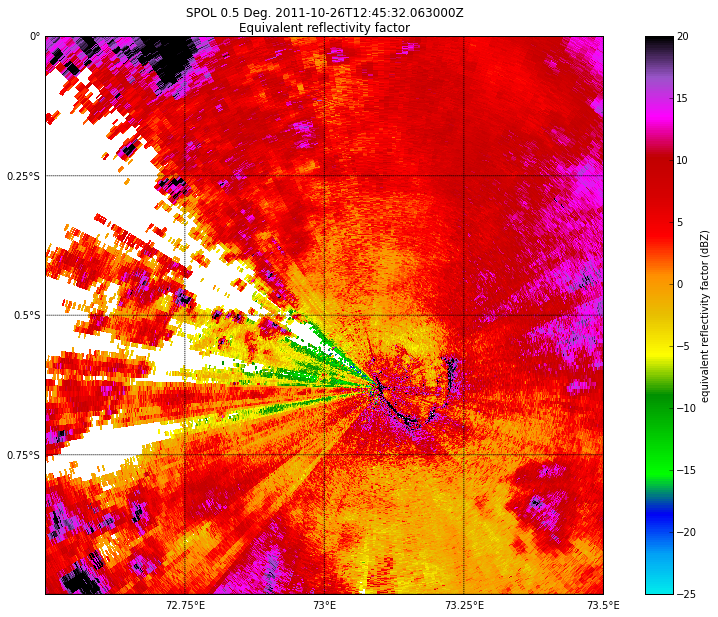

In [35]:
my_figure = plt.figure(figsize=[15,10])
my_display = pyart.graph.RadarMapDisplay(out_radar)
lat_lines = np.arange(-4,4,.25)
lon_lines = np.arange(70, 76, .25)
my_display.plot_ppi_map('mean_z', 0, 
                        lat_lines=lat_lines,
                       lon_lines=lon_lines,
                       max_lon = 73.5, max_lat = 0.,
                       min_lon = 72.5, min_lat = -1, 
                        cmap = pyart.graph.cm.NWSRef, 
                        mask_outside = False,
                       vmin = -25, vmax = 20)


In [41]:
#normalize

norm = deepcopy(out_radar.fields['mean_z']['data']*0.0)

for i in range(out_radar.nsweeps):
    si = out_radar.sweep_start_ray_index['data'][i]
    se = out_radar.sweep_end_ray_index['data'][i]
    chunk = out_radar.fields['mean_z']['data'][si:se,:]
    profile = chunk.mean(axis=0)
    norm[si:se] = chunk- profile[None, :]

In [14]:
#normalize

norm = deepcopy(out_radar.fields['mean_p']['data']*0.0)

for i in range(out_radar.nsweeps):
    si = out_radar.sweep_start_ray_index['data'][i]
    se = out_radar.sweep_end_ray_index['data'][i]
    chunk = out_radar.fields['mean_p']['data'][si:se,:]
    profile = chunk.mean(axis=0)
    norm[si:se] = chunk- profile[None, :]

In [42]:
out_radar.add_field_like('mean_z', 'norm_mean_z', norm, replace_existing=True)

In [18]:
out_radar.add_field_like('mean_p', 'norm_mean_p', norm, replace_existing=True)

KeyError: 'norm_mean_z'

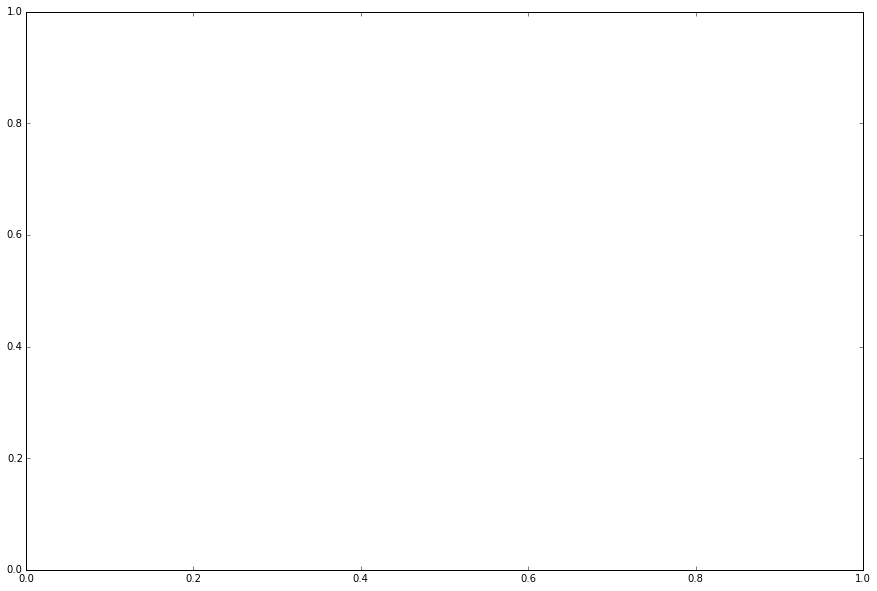

In [21]:
my_figure = plt.figure(figsize=[15,10])
my_display = pyart.graph.RadarMapDisplay(out_radar)
lat_lines = np.arange(-4,4,.25)
lon_lines = np.arange(70, 76, .25)
my_display.plot_ppi_map('norm_mean_z', 1, 
                        lat_lines=lat_lines,
                       lon_lines=lon_lines,
                       max_lon = 73.5, max_lat = 0.,
                       min_lon = 72.5, min_lat = -1, 
                        cmap = pyart.graph.cm.NWSRef, 
                        mask_outside = False,
                       vmin = -25, vmax = 20)


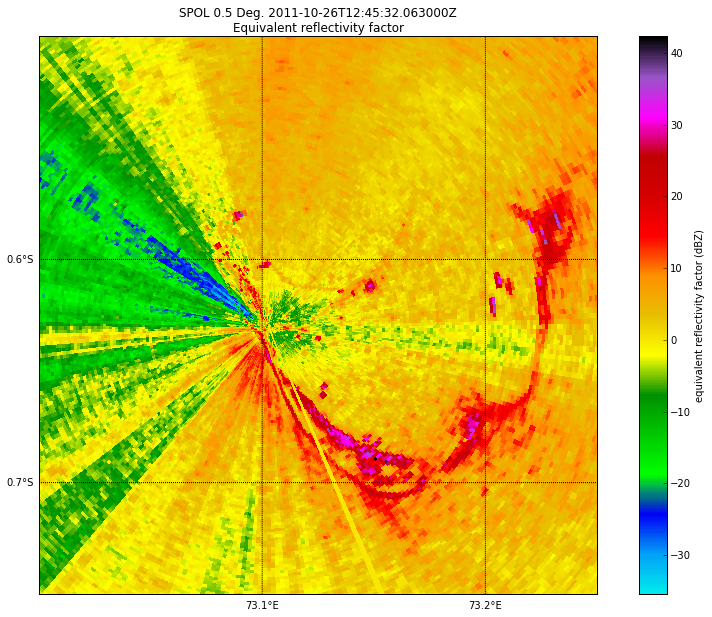

In [20]:
my_figure = plt.figure(figsize=[15,10])
my_display = pyart.graph.RadarMapDisplay(out_radar)
lat_lines = np.arange(-4,4,.1)
lon_lines = np.arange(70, 76, .1)
my_display.plot_ppi_map('norm_mean_z', 0, 
                        lat_lines=lat_lines,
                       lon_lines=lon_lines,
                       max_lon = 73.25, max_lat = -.5,
                       min_lon = 73, min_lat = -.75, 
                        cmap = pyart.graph.cm.NWSRef, 
                        mask_outside = False)


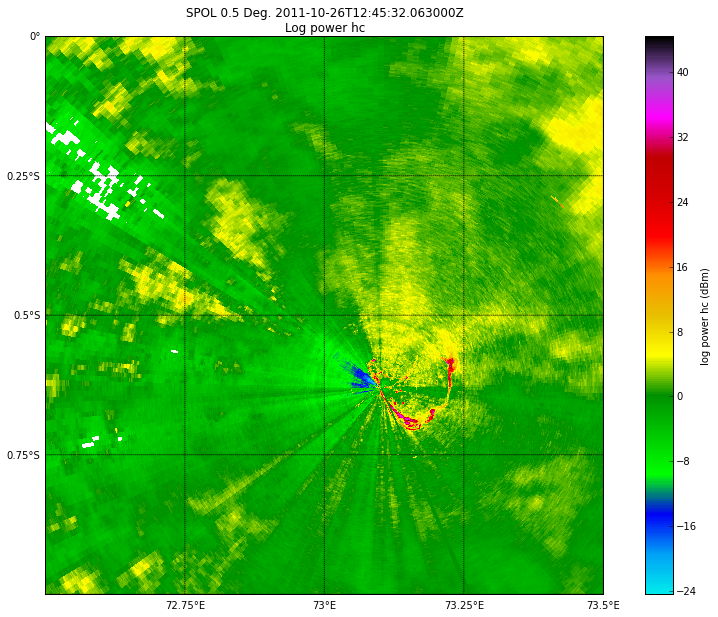

In [20]:
my_figure = plt.figure(figsize=[15,10])
my_display = pyart.graph.RadarMapDisplay(out_radar)
lat_lines = np.arange(-4,4,.25)
lon_lines = np.arange(70, 76, .25)
my_display.plot_ppi_map('norm_mean_p', 0, 
                        lat_lines=lat_lines,
                       lon_lines=lon_lines,
                       max_lon = 73.5, max_lat = 0.,
                       min_lon = 72.5, min_lat = -1, 
                        cmap = pyart.graph.cm.NWSRef, 
                        mask_outside = False)
